# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2 as cv
import typing as t
import pandas as pd
import pathlib as pb
import numpy as np
import sklearn as sk
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import normalize
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
import random as rnd
import matplotlib.pyplot as plt
import torch
import torchvision as tv
import torch.utils.data as data
from torch import Tensor
import lightning.pytorch as pl
import pickle, joblib

In [3]:
import domino.data
import domino.model
import domino.vision
import domino.preprocess
from domino.model import PretrainedCellClassifier, RandomForestCellClassifier, CellClassifier

# Environment Setup

In [4]:
# Predefined expected paths
ROOT_PATH: pb.Path = pb.Path('..')
DATA_PATH: pb.Path = ROOT_PATH / 'data'
CACHE_DIR: pb.Path = ROOT_PATH / '.cache'
MODEL_DIR: pb.Path = ROOT_PATH / '.model'
SKLRN_DIR: pb.Path = MODEL_DIR / 'sklearn'
TORCH_DIR: pb.Path = MODEL_DIR / 'torch'

# Main dataset for the given tasks
HELP_PATH: pb.Path       = DATA_PATH      / 'help'
TEST_PATH: pb.Path       = DATA_PATH      / 'test'
TRAIN_PATH: pb.Path      = DATA_PATH      / 'train'
VALID_PATH: pb.Path      = DATA_PATH      / 'valid'

# Auxiliary dataset made of grid cell patches
CELL_DATA_PATH: pb.Path  = DATA_PATH      / 'cell'
CELL_TRAIN_PATH: pb.Path = CELL_DATA_PATH / 'train'
CELL_TEST_PATH: pb.Path  = CELL_DATA_PATH / 'test'

# Obtain deterministic results
SEED = 42
rnd.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
generator: torch.Generator = torch.Generator().manual_seed(SEED)

# Configure current environment
torch.hub.set_dir(CACHE_DIR)
torch.set_float32_matmul_precision('medium')

In [5]:
# Load datasets for the task
train_dataset = domino.data.DDDGameDataset(TRAIN_PATH, train=True)
valid_dataset = domino.data.DDDGameDataset(VALID_PATH, train=True)
test_dataset  = domino.data.DDDGameDataset(TEST_PATH, train=False)

# Choose a template and a random image
template_image_board: np.ndarray = train_dataset.dataset_help.template(template_type='board', scale=0.35)
template_image_grid: np.ndarray = train_dataset.dataset_help.template(template_type='grid', scale=0.35)

# Construct necessary operations
op_board2grid = domino.vision.Board2GridOperation(show_image=False, board_template=template_image_board, grid_template=template_image_grid)
op_display    = domino.vision.DisplayOperation(scale=1.0)

# Train the models

Cell dataset already exists: ../data/cell/train
Cell dataset already exists: ../data/cell/test


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 175/175 [00:02<00:00, 58.91it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_accuracy_epoch    │    0.9981369434191468     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy_epoch': 0.9981369434191468}]

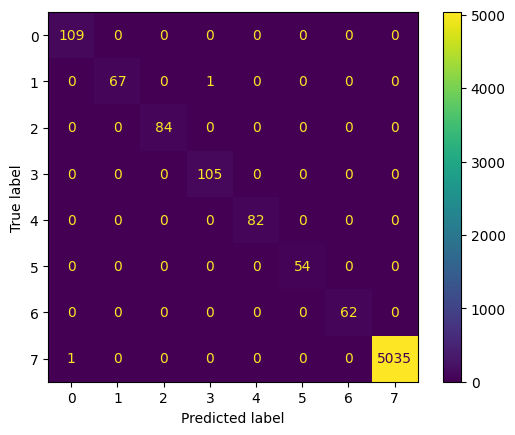

In [8]:
# Create datasets if they do not exist already
domino.data.DDDCellDataset.create_cell_dataset(CELL_TRAIN_PATH, train_dataset, op_board2grid, overwrite_imgs=False, overwrite_csv=False)
domino.data.DDDCellDataset.create_cell_dataset(CELL_TEST_PATH, valid_dataset, op_board2grid, overwrite_imgs=False, overwrite_csv=False)

# Load the train & test datasets
cell_test_dataset: data.Dataset = domino.data.DDDCellDatasetTorch(CELL_TEST_PATH)
cell_train_dataset: data.Dataset = domino.data.DDDCellDatasetTorch(CELL_TRAIN_PATH)
cell_train_valid_subsets: t.List[data.Subset] = data.random_split(cell_train_dataset, [0.8, 0.2], generator=generator)
cell_train_subset: data.Subset = cell_train_valid_subsets[0]
cell_valid_subset: data.Subset = cell_train_valid_subsets[1]

# Sample batches considering the unbalanced dataset
train_labels: Tensor = torch.tensor([cell_train_subset[i][1].item() for i in range(len(cell_train_subset))])
sample_weights, class_weights = domino.data.compute_sample_class_weights(train_labels)
weighted_sampler = data.WeightedRandomSampler(sample_weights.tolist(), 10_000)

# Create the data loaders
train_loader = data.DataLoader(cell_train_subset, batch_size=32, num_workers=4, sampler=weighted_sampler, drop_last=True)
valid_loader = data.DataLoader(cell_valid_subset, batch_size=32, num_workers=4, drop_last=True)
test_loader = data.DataLoader(cell_test_dataset, batch_size=32, num_workers=4, drop_last=True)

# Create and load the pretrained model
model = domino.model.ResNetCellClassifier(augment=True)

# Initialize the trainer
trainer = pl.Trainer(
    default_root_dir=MODEL_DIR,
    check_val_every_n_epoch=3,
    num_sanity_val_steps=0,
    deterministic=True,
    max_epochs=15,
)

# Train the model
trainer.fit(model, train_loader, valid_loader)

# # Save a checkpoint
# trainer.save_checkpoint(TORCH_DIR / 'resnet50-finetune-train.ckpt')

# Test the model
trainer.test(model, dataloaders=test_loader)

Cell dataset already exists: ../data/cell/train
Cell dataset already exists: ../data/cell/test


/home/invokariman/.cache/pypoetry/virtualenvs/double-double-dominos-R-JT3pI_-py3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/home/invokariman/.cache/pypoetry/virtualenvs/double-double-dominos-R-JT3pI_-py3.10/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/invokariman/.cache/pypoetry/virtualenvs/double-double-dominos-R-JT3pI_-py3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes`

Balanced Accuracy:  0.9470129217151146


['../.model/sklearn/balanced-random-forest.joblib']

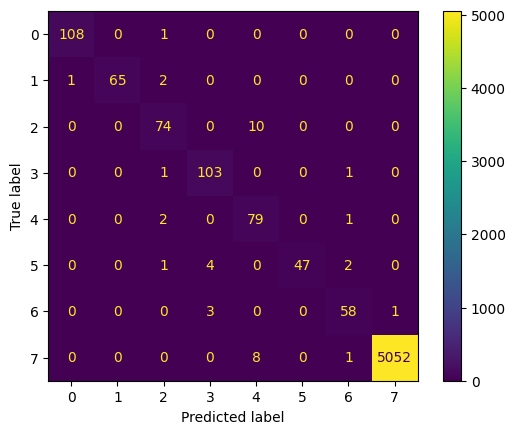

In [47]:
# Create datasets if they do not exist already
domino.data.DDDCellDataset.create_cell_dataset(CELL_TRAIN_PATH, train_dataset, op_board2grid, overwrite_imgs=False, overwrite_csv=False)
domino.data.DDDCellDataset.create_cell_dataset(CELL_TEST_PATH, valid_dataset, op_board2grid, overwrite_imgs=False, overwrite_csv=False)

# Load the train & test datasets
cell_test_dataset: data.Dataset = domino.data.DDDCellDataset(CELL_TEST_PATH)
cell_train_dataset: data.Dataset = domino.data.DDDCellDataset(CELL_TRAIN_PATH)
cell_train_valid_subsets: t.List[data.Subset] = data.random_split(cell_train_dataset, [0.8, 0.2], generator=generator)
cell_train_subset: data.Subset = cell_train_valid_subsets[0]
cell_valid_subset: data.Subset = cell_train_valid_subsets[1]

# Read entire dataset
cell_train_images, cell_train_labels = cell_train_dataset[:]
cell_test_images, cell_test_labels = cell_test_dataset[:]

# Train a classical machine learning model that is robust to unbalanced data and minimizes overfitting
model = BalancedRandomForestClassifier(n_estimators=300)

# Normalize the images
classes: np.ndarray = np.unique(cell_train_labels)
cell_train_features: np.ndarray = cell_train_images.reshape(cell_train_images.shape[0], -1)
cell_test_features: np.ndarray = cell_test_images.reshape(cell_test_images.shape[0], -1)
train_mean, train_std = cell_train_features.mean(), cell_train_features.std()
cell_train_features = (cell_train_features - train_mean) / train_std
cell_test_features = (cell_test_features - train_mean) / train_std

# Fit on the train set
model.fit(X=cell_train_features, y=cell_train_labels)

# Predict on the test set
y_true: np.ndarray = cell_test_labels
y_hat: np.ndarray = model.predict(X=cell_test_features)

# Compute metrics
accuracy: float = balanced_accuracy_score(y_true, y_hat)
cm: np.ndarray = confusion_matrix(y_true, y_hat)

# Show results
cm_disp = ConfusionMatrixDisplay(cm, display_labels=classes)
cm_disp.plot()
print('Balanced Accuracy: ', accuracy)

# Save the model
SKLRN_DIR.mkdir(parents=True, exist_ok=True)
joblib.dump(model, SKLRN_DIR / 'balanced-random-forest.joblib')

# Predict

In [71]:
# Choose a model
model_forest: CellClassifier = RandomForestCellClassifier.load_checkpoint(SKLRN_DIR / 'balanced-random-forest.joblib')
model_resnet: CellClassifier = PretrainedCellClassifier.load_checkpoint(TORCH_DIR / 'resnet50-finetune.ckpt')
model: CellClassifier = model_resnet

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [74]:
# Select a move
entry = train_dataset.dataset_bonus[5]
image, label = entry[0][0], entry[1]

# Break it into cells
grid, grid_patch, grid_cells = op_board2grid(image)

# Predict the cell contents
print(model(grid_cells))
op_display(grid_patch)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 29/29 [00:00<00:00, 36.33it/s]
[[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 1 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 1 7 7 7 7 6 7 7 7 7 7]
 [7 7 7 7 0 7 7 7 7 2 7 7 7 7 7]
 [7 7 7 7 5 5 4 4 2 2 6 7 7 7 7]
 [7 7 7 7 7 7 7 4 7 7 3 7 7 7 7]
 [7 7 7 7 7 7 7 5 7 7 2 7 7 7 7]
 [7 7 7 7 7 7 7 4 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 4 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 6 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 6 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]]
